In [ ]:
! pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from IPython.display import Image
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from surprise import SVD, Dataset, Reader
from surprise.model_selection import PredefinedKFold
from collections import defaultdict
from surprise.accuracy import rmse
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import csv
%matplotlib inline 
sns.set(style="ticks")

# Фильтрация на основе содержания. Метод k-ближайших соседей

Отзывы о винах на [Kaggle](https://www.kaggle.com/datasets/zynicide/wine-reviews)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datasets/winemag-data-130k-v2.csv')
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [ ]:
data.shape

(129971, 14)

In [ ]:
description_data = data[data['description'].notnull()]
description_data.shape

(129971, 14)

In [ ]:
title = description_data['title'].values
title[0:5]

array(['Nicosia 2013 Vulkà Bianco  (Etna)',
       'Quinta dos Avidagos 2011 Avidagos Red (Douro)',
       'Rainstorm 2013 Pinot Gris (Willamette Valley)',
       'St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore)',
       "Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley)"],
      dtype=object)

In [ ]:
descriptions = description_data['description'].values
descriptions[0:5]

array(["Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",
       "This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.",
       'Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.',
       'Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.',
       "Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it

In [ ]:
description_data.keys()

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

In [ ]:
wine_ids = description_data['Unnamed: 0'].values
wine_ids

array([     0,      1,      2, ..., 129968, 129969, 129970])

In [ ]:
%%time
tfidf = TfidfVectorizer()
description_matrix = tfidf.fit_transform(descriptions)
description_matrix

CPU times: user 4.3 s, sys: 30.3 ms, total: 4.33 s
Wall time: 4.36 s


In [ ]:
description_matrix

<129971x31275 sparse matrix of type '<class 'numpy.float64'>'
	with 4475479 stored elements in Compressed Sparse Row format>

In [ ]:
class SimplerKnnRecomender:
  def __init__(self, X_matrix, X_ids, X_title, X_overview):
        """
        Входные параметры:
        X_matrix - обучающая выборка (матрица объект-признак)
        X_ids - массив идентификаторов объектов
        X_title - массив названий объектов
        X_overview - массив описаний объектов
        """
        #Сохраняем параметры в переменных объекта
        self._X_matrix = X_matrix
        self.df = pd.DataFrame(
            {'id': pd.Series(X_ids, dtype='int'),
            'title': pd.Series(X_title, dtype='str'),
            'overview': pd.Series(X_overview, dtype='str'),
            'dist': pd.Series([], dtype='float')})
  
  def recommend_for_single_object(self, K: int, \
                X_matrix_object, cos_flag = True, manh_flag = False):
        """
        Метод формирования рекомендаций для одного объекта.
        Входные параметры:
        K - количество рекомендуемых соседей 
        X_matrix_object - строка матрицы объект-признак, соответствующая объекту
        cos_flag - флаг вычисления косинусного расстояния
        manh_flag - флаг вычисления манхэттэнского расстояния
        Возвращаемое значение: K найденных соседей
        """
        
        scale = 1000000
        # Вычисляем косинусную близость
        if cos_flag:
            dist = cosine_similarity(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=False)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] < scale]
        
        else:
            if manh_flag:
                dist = manhattan_distances(self._X_matrix, X_matrix_object)
            else:
                dist = euclidean_distances(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=True)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] > 0.0]            
        
        # Оставляем К первых рекомендаций
        res = res.head(K)
        return res

In [ ]:
test_id = 42
print(title[test_id])
print(descriptions[test_id])

Henry Fessy 2012 Nouveau  (Beaujolais)
This is a festive wine, with soft, ripe fruit and acidity, plus a red berry flavor.


In [ ]:
test_matrix = description_matrix[test_id]
test_matrix

<1x31275 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [ ]:
skr1 = SimplerKnnRecomender(description_matrix, wine_ids, title, descriptions)

In [ ]:
# 15 вин, наиболее похожих на Henry Fessy 2012 Nouveau  (Beaujolais)
# в порядке убывания схожести на основе косинусного сходства
rec1 = skr1.recommend_for_single_object(15, test_matrix)
rec1

,id,title,overview,dist
25661,25661,Bernard Magrez 2010 Maison Magrez (Bordeaux),"A textured wine, this has ripe fruit that stil...",363153.236583
97200,97200,Pierre Sparr NV Brut Rosé Sparkling (Crémant d...,An extremely lively mousse gives this wine an ...,359546.956181
115406,115406,D.R. Stephens 2011 Chardonnay (Rutherford),Though not much Chardonnay is grown in Rutherf...,359272.173824
13490,13490,Hosmer NV Brut Rosé Pinot Noir (Cayuga Lake),"Almost garnet red in color, this off-dry Pinot...",332125.889470
7666,7666,Hosmer NV Brut Rosé Pinot Noir (Cayuga Lake),"Almost garnet red in color, this off-dry Pinot...",332125.889470
101476,101476,Domaine Luquet 2011 Les Mulots (Mâcon-Villages),"Soft and simple, this has a pear flavor, a tou...",324610.018728
31154,31154,Terlato 2009 Cabernet Sauvignon (Stags Leap Di...,"Another voluptuous Cabernet from Terlato, this...",319808.034261
112634,112634,DFJ Vinhos 2008 Fonte do Beco Castelão (Setubal),"Soft, ripe, juicy wine, full of bright red ber...",313485.970488
43574,43574,Louis Latour 2013 Chameroy (Mâcon-Villages),This is a soft and ripe wine with acidity plus...,310769.996740
971,971,Pommery NV Pop Rosé Extra Dry (Champagne),Although it is labeled “Extra Dry” (that is sw...,308033.751795


In [ ]:
# При поиске с помощью Евклидова расстояния получаем такой же результат
rec2 = skr1.recommend_for_single_object(15, test_matrix, cos_flag = False)
rec2

,id,title,overview,dist
25661,25661,Bernard Magrez 2010 Maison Magrez (Bordeaux),"A textured wine, this has ripe fruit that stil...",1.128580e+06
97200,97200,Pierre Sparr NV Brut Rosé Sparkling (Crémant d...,An extremely lively mousse gives this wine an ...,1.131771e+06
115406,115406,D.R. Stephens 2011 Chardonnay (Rutherford),Though not much Chardonnay is grown in Rutherf...,1.132014e+06
13490,13490,Hosmer NV Brut Rosé Pinot Noir (Cayuga Lake),"Almost garnet red in color, this off-dry Pinot...",1.155746e+06
7666,7666,Hosmer NV Brut Rosé Pinot Noir (Cayuga Lake),"Almost garnet red in color, this off-dry Pinot...",1.155746e+06
101476,101476,Domaine Luquet 2011 Les Mulots (Mâcon-Villages),"Soft and simple, this has a pear flavor, a tou...",1.162231e+06
31154,31154,Terlato 2009 Cabernet Sauvignon (Stags Leap Di...,"Another voluptuous Cabernet from Terlato, this...",1.166355e+06
112634,112634,DFJ Vinhos 2008 Fonte do Beco Castelão (Setubal),"Soft, ripe, juicy wine, full of bright red ber...",1.171763e+06
43574,43574,Louis Latour 2013 Chameroy (Mâcon-Villages),This is a soft and ripe wine with acidity plus...,1.174078e+06
971,971,Pommery NV Pop Rosé Extra Dry (Champagne),Although it is labeled “Extra Dry” (that is sw...,1.176407e+06


In [ ]:
# Манхэттэнское расстояние дает несколько иные результаты поиска
rec3 = skr1.recommend_for_single_object(15, test_matrix, 
                                        cos_flag = False, manh_flag = True)
rec3

,id,title,overview,dist
98370,98370,Cannonball 2010 Cabernet Sauvignon (California),"A soft wine, with diluted berry and cherry fla...",3.852076e+06
63957,63957,Parras Vinhos NV Filigrana Rosé (Lisboa),With an attractive fresh prickle on the palate...,3.943114e+06
127161,127161,Dahlia 2010 Reserve Pinot Noir (Monterey County),"This is soft, sweet and syrupy, with a cherry ...",4.002339e+06
29938,29938,Quinta Dona Matilde 2014 Tinto Red (Douro),"Ripe with red-berry flavors, this wine is fres...",4.129606e+06
35511,35511,Château Lalande Méric 2014 Rosé (Bordeaux Rosé),This neutral-tasting wine has little flavor. I...,4.225791e+06
43552,43552,Dona Maria-Júlio Bastos 2014 Dona Maria Rosé (...,"This is a soft, fresh wine, with attractive re...",4.239399e+06
14551,14551,Dona Maria-Júlio Bastos 2014 Dona Maria Rosé (...,"This is a soft, fresh wine, with attractive re...",4.239399e+06
29475,29475,Judith Beck 2009 Zweigelt (Burgenland),"A tasty, juicy wine with ripe red cherry fruit...",4.245180e+06
21783,21783,Estancia 2006 Keyes Canyon Ranches Zinfandel (...,"Dull and soft, with vegetal and candied berry ...",4.275616e+06
76704,76704,Casa Santos Lima 2014 Portuga White (Lisboa),"This wine is soft and bland, just hinting at f...",4.289356e+06


# Коллаборативная фильтрация. Метод на основе сингулярного разложения

The [Book-Crossing dataset](https://www.kaggle.com/datasets/somnambwl/bookcrossing-dataset) comprises 3 tables.
- BX-Users

Contains the users. Note that user IDs (`User-ID`) have been anonymized and map to integers. Demographic data is provided (`Location`, `Age`) if available. Otherwise, these fields contain NULL-values.

- BX-Books

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), i.e., small, medium, large. These URLs point to the Amazon web site.

- BX-Book-Ratings

Contains the book rating information. Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

### Другое

In [ ]:
books = pd.read_csv('/content/drive/MyDrive/datasets/BX-Books.csv', sep = ';', encoding='latin-1')
books.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,NaN,NaN,NaN
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,NaN,NaN,NaN
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,NaN,NaN,NaN
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,NaN,NaN,NaN
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,NaN,NaN,NaN


In [ ]:
users = pd.read_csv('/content/drive/MyDrive/datasets/BX-Users.csv', sep = ';', encoding='latin-1', quoting=csv.QUOTE_ALL)
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/datasets/BX-Book-Ratings.csv', sep = ';', encoding='latin-1', quoting=csv.QUOTE_ALL)
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
# ratings = ratings[:12000]

In [ ]:
books.shape, users.shape, ratings.shape

((271378, 11), (278858, 3), (1149780, 3))

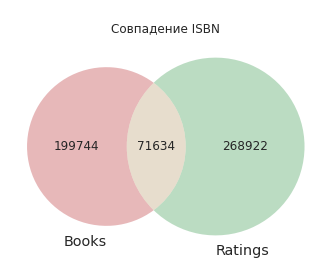

In [ ]:
plt.title('\nСовпадение ISBN')
venn2([set(books['ISBN'].unique()), set(ratings['ISBN'].unique())], set_labels = ('Books', 'Ratings'))

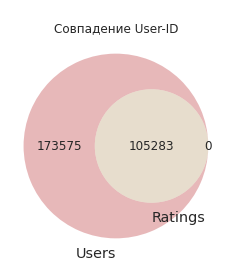

In [ ]:
plt.title('\nСовпадение User-ID')
venn2([set(users['User-ID'].unique()), set(ratings['User-ID'].unique())], set_labels = ('Users', 'Ratings'))

In [ ]:
data = pd.merge(ratings, users, on = 'User-ID')
data.head()

,User-ID,ISBN,Book-Rating,Location,Age
0,276725,034545104X,0,"tyler, texas, usa",NaN
1,276726,0155061224,5,"seattle, washington, usa",NaN
2,276727,0446520802,0,"h, new south wales, australia",16.0
3,276729,052165615X,3,"rijeka, n/a, croatia",16.0
4,276729,0521795028,6,"rijeka, n/a, croatia",16.0


In [ ]:
data.shape

(1149780, 5)

In [ ]:
data = data.merge(books)
data.head()

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,276725,034545104X,0,"tyler, texas, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,NaN,NaN,NaN
1,2313,034545104X,5,"cincinnati, ohio, usa",23.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,NaN,NaN,NaN
2,6543,034545104X,0,"strafford, missouri, usa",34.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,NaN,NaN,NaN
3,8680,034545104X,5,"st. charles county, missouri, usa",2.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,NaN,NaN,NaN
4,10314,034545104X,9,"beaverton, oregon, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,NaN,NaN,NaN


In [ ]:
data.shape

(196842, 15)

In [ ]:
data.drop(['Image-URL-S',	'Image-URL-M', 'Image-URL-L', 'Unnamed: 8',	'Unnamed: 9',	'Unnamed: 10'], axis = 1)

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,"tyler, texas, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,2313,034545104X,5,"cincinnati, ohio, usa",23.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
2,6543,034545104X,0,"strafford, missouri, usa",34.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
3,8680,034545104X,5,"st. charles county, missouri, usa",2.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
4,10314,034545104X,9,"beaverton, oregon, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
...,...,...,...,...,...,...,...,...,...
196837,276680,086505505X,0,"hopewell junction, new york, usa",55.0,Home Crafts (Historic Communities (Paperback)),Bobbie Kalman,1990,Crabtree Publishing Company
196838,276680,1564407284,0,"hopewell junction, new york, usa",55.0,"The Old Sturbridge Village Cookbook, 2nd : Aut...",Caroline Sloat,1995,Globe Pequot
196839,276680,1582343594,0,"hopewell junction, new york, usa",55.0,City of Masks : A Cree Black Novel,Daniel Hecht,2004,Bloomsbury USA
196840,276681,1931333246,10,"chicago, illinois, usa",43.0,Chorus,Kurt Messick,2003,Dry Bones Press


### Загрузка датасета

In [ ]:
#Loading the Data Set
book = pd.read_csv('/content/drive/MyDrive/datasets/Books.csv',low_memory=False)
rating = pd.read_csv('/content/drive/MyDrive/datasets/Ratings.csv',low_memory=False)
users = pd.read_csv('/content/drive/MyDrive/datasets/Users.csv',low_memory=False)

df1=book.merge(rating,how="left", on="ISBN")
df_=df1.merge(users,how="left", on="User-ID")

df=df_.copy()
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2.0,0.0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8.0,5.0,"timmins, ontario, canada",NaN
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400.0,0.0,"ottawa, ontario, canada",49.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676.0,8.0,"n/a, n/a, n/a",NaN
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385.0,0.0,"sudbury, ontario, canada",NaN


In [ ]:
df.shape

(1032345, 12)

In [ ]:
#Deleting missing observations in the dataset
df.info()
df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1032345 entries, 0 to 1032344
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ISBN                 1032345 non-null  object 
 1   Book-Title           1032345 non-null  object 
 2   Book-Author          1032344 non-null  object 
 3   Year-Of-Publication  1032345 non-null  object 
 4   Publisher            1032343 non-null  object 
 5   Image-URL-S          1032345 non-null  object 
 6   Image-URL-M          1032345 non-null  object 
 7   Image-URL-L          1032341 non-null  object 
 8   User-ID              1031136 non-null  float64
 9   Book-Rating          1031136 non-null  float64
 10  Location             1031136 non-null  object 
 11  Age                  753301 non-null   float64
dtypes: float64(3), object(9)
memory usage: 102.4+ MB


In [ ]:
#Converting User-ID and Age variable types to int
df['User-ID'] = df['User-ID'].astype('int')
df['Age'] = df['Age'].astype('int')
df['Book-Rating'] = df['Book-Rating'].astype('int')
# df['ISBN'] = df['ISBN'].astype('int')

In [ ]:
#Extracting Image URL from dataset
df.drop(columns=["Image-URL-S","Image-URL-M","Image-URL-L"],inplace=True)

In [ ]:
#Removing books with zero ratings from the data set
df=df[df["Book-Rating"]>0]
df["Book-Rating"].describe()

count    269617.000000
mean          7.736152
std           1.814537
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: Book-Rating, dtype: float64

In [ ]:
# Количество уникальных пользователей
df["User-ID"].nunique()

40543

In [ ]:
# Количество уникальных книг
df["ISBN"].nunique()

119944

In [ ]:
# Сформируем матрицу взаимодействий на основе рейтингов
# Используется идея из статьи - https://towardsdatascience.com/beginners-guide-to-creating-an-svd-recommender-system-1fd7326d1f65
def create_utility_matrix(data):
    itemField = 'ISBN'
    userField = 'User-ID'
    valueField = 'Book-Rating'  
    
    userList = data[userField].tolist()
    itemList = data[itemField].tolist()
    valueList = data[valueField].tolist()    
    
    users = list(set(userList))
    users.sort()
    items = list(set(itemList))    
    
    users_index = {users[i]: i for i in range(len(users))}    
    pd_dict = {item: [0.0 for i in range(len(users))] for item in items}    
    
    for i in range(0,data.shape[0]):
        item = itemList[i]
        user = userList[i]
        value = valueList[i]    
        pd_dict[item][users_index[user]] = value    
    
    X = pd.DataFrame(pd_dict)
    X.index = users
        
    itemcols = list(X.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}
    
    return X, users_index, items_index

In [ ]:
mini_df = df[:70000]
mini_df.reset_index(drop=True, inplace=True)
mini_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,67544,8,"toronto, ontario, canada",30
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,219008,7,"halifax, nova scotia, canada",60
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,263325,6,"fredericton, new brunswick, canada",27
3,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,2954,8,"wichita, kansas, usa",71
4,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,152827,7,"ottawa, ontario, canada",40


In [ ]:
#We found how many books users read
mini_df.groupby('User-ID')['Book-Title'].agg('count')

User-ID
19         1
42         1
44         1
51         1
56         2
          ..
278836     1
278843    11
278844     1
278846     1
278851     2
Name: Book-Title, Length: 20593, dtype: int64

In [ ]:
%%time
user_item_matrix, users_index, items_index = create_utility_matrix(mini_df)

CPU times: user 26.1 s, sys: 2.53 s, total: 28.6 s
Wall time: 32.6 s


In [ ]:
user_item_matrix

,0345423135,0802116825,1570717257,0778320324,3596154766,1558506462,0140244824,0060809833,0373710208,0553225448,...,0590425919,0449221032,0451408888,881787017X,0380016974,0446600342,0872860175,1863739157,0553213938,0449005615
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Выделение тестовой строки
user_item_matrix__test = user_item_matrix.loc[[278843]]
user_item_matrix__test

,0345423135,0802116825,1570717257,0778320324,3596154766,1558506462,0140244824,0060809833,0373710208,0553225448,...,0590425919,0449221032,0451408888,881787017X,0380016974,0446600342,0872860175,1863739157,0553213938,0449005615
278843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
mini_df.loc[mini_df['User-ID'] == 278843]['ISBN'].value_counts()

0060173289    1
0142000205    1
059035342X    1
0553274503    1
0399146431    1
0786881852    1
0440211263    1
0767902890    1
0060517794    1
014028009X    1
0679412956    1
Name: ISBN, dtype: int64

In [ ]:
# Оставшаяся часть матрицы для обучения
user_item_matrix__train = user_item_matrix.loc[:278842]
user_item_matrix__train

,0345423135,0802116825,1570717257,0778320324,3596154766,1558506462,0140244824,0060809833,0373710208,0553225448,...,0590425919,0449221032,0451408888,881787017X,0380016974,0446600342,0872860175,1863739157,0553213938,0449005615
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
%%time
U, S, VT = np.linalg.svd(user_item_matrix__train.T)
V = VT.T

CPU times: user 26min 39s, sys: 43.8 s, total: 27min 23s
Wall time: 14min 12s


In [ ]:
# Матрица соотношения между пользователями и латентными факторами
U.shape

(7072, 7072)

In [ ]:
# Матрица соотношения между объектами и латентными факторами
V.shape

(20589, 20589)

In [ ]:
S.shape

(7072,)

In [ ]:
Sigma = np.diag(S)
Sigma.shape

(7072, 7072)

In [ ]:
# Диагональная матрица сингулярных значений
Sigma

array([[2.54396456e+02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.83090503e+02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.72302131e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.02792936e-15, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.11489214e-15, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.51037375e-16]])

In [ ]:
# Используем 3 первых сингулярных значения
r=3
Ur = U[:, :r]
Sr = Sigma[:r, :r]
Vr = V[:, :r]

In [ ]:
# Матрица соотношения между новым пользователем и латентными факторами
test_user = np.mat(user_item_matrix__test.values)
test_user.shape, test_user

((1, 7072), matrix([[0., 0., 0., ..., 0., 0., 0.]]))

In [ ]:
tmp = test_user * Ur * np.linalg.inv(Sr)
tmp

matrix([[-0.01219295, -0.0116509 , -0.00380956]])

In [ ]:
test_user_result = np.array([tmp[0,0], tmp[0,1], tmp[0,2]])
test_user_result

array([-0.01219295, -0.0116509 , -0.00380956])

In [ ]:
# Вычисляем косинусную близость между текущим пользователем 
# и остальными пользователями
cos_sim = cosine_similarity(Vr, test_user_result.reshape(1, -1))
cos_sim[:10]

array([[ 2.66548790e-01],
       [ 3.39733139e-01],
       [ 9.93712015e-01],
       [ 7.93459263e-01],
       [ 5.93003134e-01],
       [-3.23659713e-19],
       [ 5.76230937e-18],
       [ 9.78196289e-18],
       [ 9.28384215e-01],
       [ 9.14378425e-01]])

In [ ]:
# Преобразуем размерность массива
cos_sim_list = cos_sim.reshape(-1, cos_sim.shape[0])[0]
cos_sim_list[:10]

array([ 2.66548790e-01,  3.39733139e-01,  9.93712015e-01,  7.93459263e-01,
        5.93003134e-01, -3.23659713e-19,  5.76230937e-18,  9.78196289e-18,
        9.28384215e-01,  9.14378425e-01])

In [ ]:
np.argsort(-cos_sim_list)

array([19424,  7833, 20417, ..., 15400,  4622,   530])

In [ ]:
# Находим наиболее близкого пользователя
recommended_user_id = np.argsort(-cos_sim_list)[0]
recommended_user_id

19424

In [ ]:
# Получение названия фильма
bookId_list = list(user_item_matrix.columns)
def film_name_by_movieid(ind):
    try:
        bookId = bookId_list[ind]
        book = mini_df.loc[mini_df['ISBN'] == bookId]['Book-Title'].values[0]
        # flt_links = df_links[df_links['movieId'] == movieId]
        # tmdbId = int(flt_links['tmdbId'].values[0])
        # md_links = df_md[df_md['id'] == tmdbId]
        # res = md_links['title'].values[0]
        return book
    except:
        return '' 

In [ ]:
# Фильмы, которые оценивал текущий пользователь:
i=1
for idx, item in enumerate(np.ndarray.flatten(np.array(test_user))):
    if item > 0:
        film_title = film_name_by_movieid(idx)
        print('{} - {} - {}'.format(idx, film_title, item))
        if i==20:
            break
        else:
            i+=1

331 - Bridget Jones's Diary - 8.0
856 - Circle of Friends - 7.0
868 - The Things They Carried - 9.0
2798 - Flowers for Algernon (Bantam Classic) - 8.0
3681 - Little Altars Everywhere - 7.0
4057 - Don't Sweat the Small Stuff and It's All Small Stuff : Simple Ways to Keep the Little Things from Taking Over Your Life (Don't Sweat the Small Stuff Series) - 8.0
4531 - Divine Secrets of the Ya-Ya Sisterhood : A Novel - 9.0
5801 - Icy Sparks - 9.0
5953 - Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) - 8.0
6186 - Lasher - 8.0
6245 - The Bonesetter's Daughter - 9.0


In [ ]:
# Фильмы, которые оценивал наиболее схожий пользователь:
i=1
recommended_user_item_matrix = user_item_matrix.loc[[recommended_user_id]]
for idx, item in enumerate(np.ndarray.flatten(np.array(recommended_user_item_matrix))):
    if item > 0:
        film_title = film_name_by_movieid(idx)
        print('{} - {} - {}'.format(idx, film_title, item))
        if i==20:
            break
        else:
            i+=1

2856 - The Corrections: A Novel - 9.0


## Альтернативный подход

In [ ]:
#Loading the Data Set
book = pd.read_csv('/content/drive/MyDrive/datasets/Books.csv',low_memory=False)
rating = pd.read_csv('/content/drive/MyDrive/datasets/Ratings.csv',low_memory=False)
users = pd.read_csv('/content/drive/MyDrive/datasets/Users.csv',low_memory=False)

df1=book.merge(rating,how="left", on="ISBN")
df_=df1.merge(users,how="left", on="User-ID")

df=df_.copy()
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2.0,0.0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8.0,5.0,"timmins, ontario, canada",NaN
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400.0,0.0,"ottawa, ontario, canada",49.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676.0,8.0,"n/a, n/a, n/a",NaN
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385.0,0.0,"sudbury, ontario, canada",NaN


In [ ]:
#Deleting missing observations in the dataset
df.info()
df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1032345 entries, 0 to 1032344
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ISBN                 1032345 non-null  object 
 1   Book-Title           1032345 non-null  object 
 2   Book-Author          1032344 non-null  object 
 3   Year-Of-Publication  1032345 non-null  object 
 4   Publisher            1032343 non-null  object 
 5   Image-URL-S          1032345 non-null  object 
 6   Image-URL-M          1032345 non-null  object 
 7   Image-URL-L          1032341 non-null  object 
 8   User-ID              1031136 non-null  float64
 9   Book-Rating          1031136 non-null  float64
 10  Location             1031136 non-null  object 
 11  Age                  753301 non-null   float64
dtypes: float64(3), object(9)
memory usage: 102.4+ MB


In [ ]:
#Converting User-ID and Age variable types to int
df['User-ID'] = df['User-ID'].astype('int')
df['Age'] = df['Age'].astype('int')

In [ ]:
#Extracting Image URL from dataset
df.drop(columns=["Image-URL-S","Image-URL-M", "Image-URL-L"],inplace=True)

In [ ]:
#Removing books with zero ratings from the data set
df=df[df["Book-Rating"]>0]
df["Book-Rating"].describe()

count    269617.000000
mean          7.736152
std           1.814537
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: Book-Rating, dtype: float64

In [ ]:
#How many times have we read which book?
book_counts = pd.DataFrame(df["Book-Title"].value_counts())

In [ ]:
#Most read books
book_counts.sort_values("Book-Title", ascending=False)

,Book-Title
Wild Animus,473
The Lovely Bones: A Novel,473
The Da Vinci Code,380
The Secret Life of Bees,280
Bridget Jones's Diary,261
...,...
WEEPING ANGEL : WEEPING ANGEL,1
Was die Welt nicht braucht. Von Chatten bis Waschbrettbauch.,1
Knitting Masterpieces,1
I Don't Know What to Say,1


In [ ]:
#We named the books with less than 100 reads as rare books.
rare_book = book_counts[book_counts["Book-Title"] <= 100].index

In [ ]:
#Number of rarely read books
rare_book.nunique()

109118

In [ ]:
#By removing the rare books from the dataset, we found the widely read books
common_book = df[~df["Book-Title"].isin(rare_book)]
common_book.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
108,0440234743,The Testament,John Grisham,1999,Dell,7346,9.0,"sunnyvale, california, usa",49
109,0440234743,The Testament,John Grisham,1999,Dell,7352,8.0,"houston, texas, usa",53
113,0440234743,The Testament,John Grisham,1999,Dell,11224,6.0,"tumwater, washington, usa",51
116,0440234743,The Testament,John Grisham,1999,Dell,12923,10.0,"louisville, kentucky, usa",39
117,0440234743,The Testament,John Grisham,1999,Dell,13552,8.0,"cordova, tennessee, usa",32


In [ ]:
#User-Book matrix
user_book_df = common_book.pivot_table(index=["User-ID"], columns=["Book-Title"], values="Book-Rating")
user_book_df

Book-Title,1984,1st to Die: A Novel,A Painted House,A Prayer for Owen Meany,A Time to Kill,A Walk to Remember,American Gods,Angels &amp; Demons,Bel Canto: A Novel,Bridget Jones's Diary,...,"The Vampire Lestat (Vampire Chronicles, Book II)",Timeline,To Kill a Mockingbird,"Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson",Watership Down,Where the Heart Is (Oprah's Book Club (Paperback)),White Oleander : A Novel,White Oleander : A Novel (Oprah's Book Club),Wicked: The Life and Times of the Wicked Witch of the West,Wild Animus
User-ID,,,,,,,,,,,,,,,,,,,,,
51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN


In [ ]:
#We chose a book
book_name="Fahrenheit 451"

In [ ]:
#We found the points given to the book
book_name=user_book_df[book_name]
book_name.sort_values(ascending=False)

User-ID
63367     10.0
83431     10.0
52199     10.0
203075    10.0
69023     10.0
          ... 
278653     NaN
278683     NaN
278798     NaN
278800     NaN
278843     NaN
Name: Fahrenheit 451, Length: 7608, dtype: float64

In [ ]:
user_book_df.corrwith(book_name).sort_values(ascending=False).head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Book-Title
1st to Die: A Novel                  1.0
Fahrenheit 451                       1.0
A Walk to Remember                   1.0
Little Altars Everywhere: A Novel    1.0
Angels &amp; Demons                  1.0
dtype: float64

In [ ]:
rec_book=user_book_df.corrwith(book_name).sort_values(ascending=False).head(10)
rec_book_list=list(rec_book.index)

rec_book_list

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


['1st to Die: A Novel',
 'Fahrenheit 451',
 'A Walk to Remember',
 'Little Altars Everywhere: A Novel',
 'Angels &amp; Demons',
 'Digital Fortress : A Thriller',
 "Harry Potter and the Sorcerer's Stone (Book 1)",
 "White Oleander : A Novel (Oprah's Book Club)",
 'Girl with a Pearl Earring',
 'Jurassic Park']

In [ ]:
#Authors of 5 books we recommend
df_author=df[["Book-Title","Book-Author"]]
df_author.head()

df1 = df_author.loc[df_author["Book-Title"].isin(rec_book_list)]

df2=df1.drop_duplicates(subset=["Book-Author","Book-Author"], keep="first")
df2

,Book-Title,Book-Author
9759,Angels &amp; Demons,Dan Brown
11009,Little Altars Everywhere: A Novel,Rebecca Wells
12982,Fahrenheit 451,Ray Bradbury
16075,Girl with a Pearl Earring,Tracy Chevalier
59234,Jurassic Park,Michael Crichton
86198,1st to Die: A Novel,James Patterson
97544,Fahrenheit 451,RAY BRADBURY
114697,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling
131689,Jurassic Park,MICHAEL CRICHTON
154175,White Oleander : A Novel (Oprah's Book Club),Janet Fitch
